# Simulation of modern and ancient samples in 2 populations

This model assumes that populations have been subdivided for a very long time and that equilibrium has been established.<br>
It models ongoing gene flow. <br>
In many cases, this may not be a realistic model of population subdivision.

In [1]:
import msprime
import allel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def modernSamples(n, deme):
    """
    n = number of modern samples (haploids)
    deme = the number of the deme the samples belong to
    """
    samples = []
    for i in range(0,n):
        samples.append(msprime.Sample(deme,0))
    return(samples)


def ancientSamples(nb, age, deme):
    """
    nb = number of ancient samples (haploids)
    age = age of the samples, in generations
    deme = the number of the deme the samples belong to
    """
    samples = []
    for i in range(0,nb):
        samples.append(msprime.Sample(deme, age))
    return(samples)

def createSamples(nbM, nbA, ages, pop1, pop2):
    """
    nbM = number of modern samples (diploids)
    nbA = number of ancient samples (diploids)
    age = list of past generations for ancient samples
    """
    samples = modernSamples(2*nbM, pop1)
    for i in ages[1:]:
        samples += ancientSamples(2*nbA, i, pop1)
    samples += modernSamples(2*nbM, pop2)
    for i in ages[1:]:
        samples += ancientSamples(2*nbA, i, pop2)
#     samples += modernSamples(2*nbM, pop3)
#     for i in ages:
#         samples += ancientSamples(2*nbA, i, pop3)
#     samples += modernSamples(2*nbM, pop4)
#     for i in ages:
#         samples += ancientSamples(2*nbA, i, pop4)
    return samples

In [16]:
nbM = 10 # number of modern samples
nbA = 1 # number of ancient samples
ages = [0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000] # ages of the ancient samples

samples = createSamples(nbM, nbA, ages, 0, 1)

In [17]:
nbPops = 2
population_configurations=[
        msprime.PopulationConfiguration(),
        msprime.PopulationConfiguration()]

m = 1 / (4 * 15000)

migration_matrix=[
        [0, m],
        [m, 0]]

In [18]:
def segregating_sites_examples(num_replicates, nbA, nbM, nbPops):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order get thousands of independent SNPs.
    """
    s = 0
    replicates = msprime.simulate(Ne=15000, length= 100, samples = samples,
                                  mutation_rate=1e-8, recombination_rate=1e-8,
                                  num_replicates=num_replicates,
                                 migration_matrix = migration_matrix, population_configurations = population_configurations)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbPops*(nbM + nbA*(len(ages)-1)),2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

In [19]:
g = allel.model.GenotypeArray(segregating_sites_examples(5000, nbA, nbM, nbPops))
g

<GenotypeArray shape=(3445, 40, 2) dtype=int8>
0/0 0/1 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/1 1/0 1/1 1/0 1/1
0/1 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 1/0 0/0 ... 1/1 1/1 1/1 1/1 1/1

In [20]:
times1 = list(map(str, ages))
times1 = ["1_" + l for l in times1]
times2 = list(map(str, ages))
times2 = ["2_" + l for l in times2]

In [27]:
gn = g.to_n_alt()[:]

# with open("genotype_2pop_temp.txt", "w") as f:
#     for ind in np.arange(gn.shape[1]):
#         for var in np.arange(gn.shape[0]):
#             if var != gn.shape[0]-1:
#                 f.write("%s\t" % gn[var, ind])
#             else:
#                 f.write("%s\n" % gn[var, ind])
                
with open("generations_2pop_temp.txt", "w") as f:
    all_ages  = ages + ages
    for a in all_ages:
        if a == 0:
            for i in np.arange(nbM):
                f.write("%s\n" % a)
        else:
            for i in np.arange(nbA):
                f.write("%s\n" % a)

coords, model = allel.stats.pca(gn, scaler=None)
coords.shape

(40, 10)

In [22]:
palette1 = sns.color_palette("hls", len(times1))
palette2 = sns.cubehelix_palette(len(times2), start=2, rot=0, dark=0, light=.95, reverse=True)
i = 0
colors1 = {}
for t in times1:
    colors1[t] = palette1[i]
    i += 1
i = 0
colors2 = {}
for t in times2:
    colors2[t] = palette2[i]
    i += 1

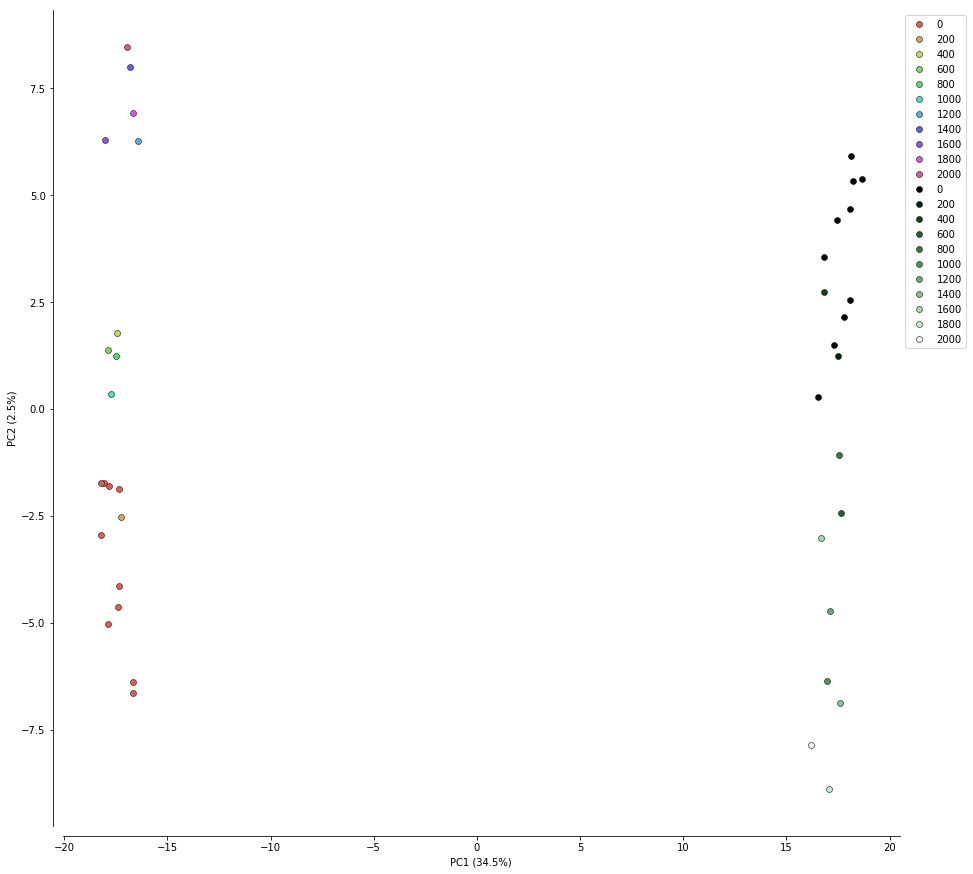

In [24]:
def plot_pca_coords(coords, model, pc1, pc2, ax):
    i = 0
    ## pop1
    # modern samples
    x = coords[0:nbM, pc1]
    y = coords[0:nbM, pc2]
    ax.plot(x, y, marker='o', linestyle=' ', label=str(0), color=colors1['1_' + str(0)], markersize=6, mec='k', mew=.5)
    i += nbM
    # ancient samples
    for a in ages[1:]:
        x = coords[i:i+nbA, pc1]
        y = coords[i:i+nbA, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=str(a),
                color=colors1["1_" + str(a)], markersize=6, mec='k', mew=.5)
        i += nbA
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
    i = nbM + (len(ages)-1) * nbA
    ## pop2
    # modern samples
    x = coords[i:i+nbM, pc1]
    y = coords[i:i+nbM, pc2]
    ax.plot(x, y, marker='o', linestyle=' ', label=str(0), color=colors2['2_' + str(0)], markersize=6, mec='k', mew=.5)
    i += nbM
    # ancient samples
    for a in ages[1:]:
        x = coords[i:i+nbA, pc1]
        y = coords[i:i+nbA, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=str(a),
                color=colors2["2_" + str(a)], markersize=6, mec='k', mew=.5)
        i += nbA
    """
    i = 2*(nbM + len(ages) * nbA)
    ## pop3
    # modern samples
    x = coords[i:i+nbM, pc1]
    y = coords[i:i+nbM, pc2]
    ax.plot(x, y, marker='o', linestyle=' ', label='modern', color=colors3['3_modern'], markersize=6, mec='k', mew=.5)
    i += nbM
    # ancient samples
    for a in ages:
        x = coords[i:i+nbA, pc1]
        y = coords[i:i+nbA, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=str(a),
                color=colors3["3_" + str(a)], markersize=6, mec='k', mew=.5)
        i += nbM
        
    i = 3*(nbM + len(ages) * nbA)
    ## pop4
    # modern samples
    x = coords[i:i+nbM, pc1]
    y = coords[i:i+nbM, pc2]
    ax.plot(x, y, marker='o', linestyle=' ', label='modern', color=colors4['4_modern'], markersize=6, mec='k', mew=.5)
    i += nbM
    # ancient samples
    for a in ages:
        x = coords[i:i+nbA, pc1]
        y = coords[i:i+nbA, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=str(a),
                color=colors4["4_" + str(a)], markersize=6, mec='k', mew=.5)
        i += nbM
    """
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
fig, ax = plt.subplots(figsize=(15, 15))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

Text(0.5,1.02,'PC maps')

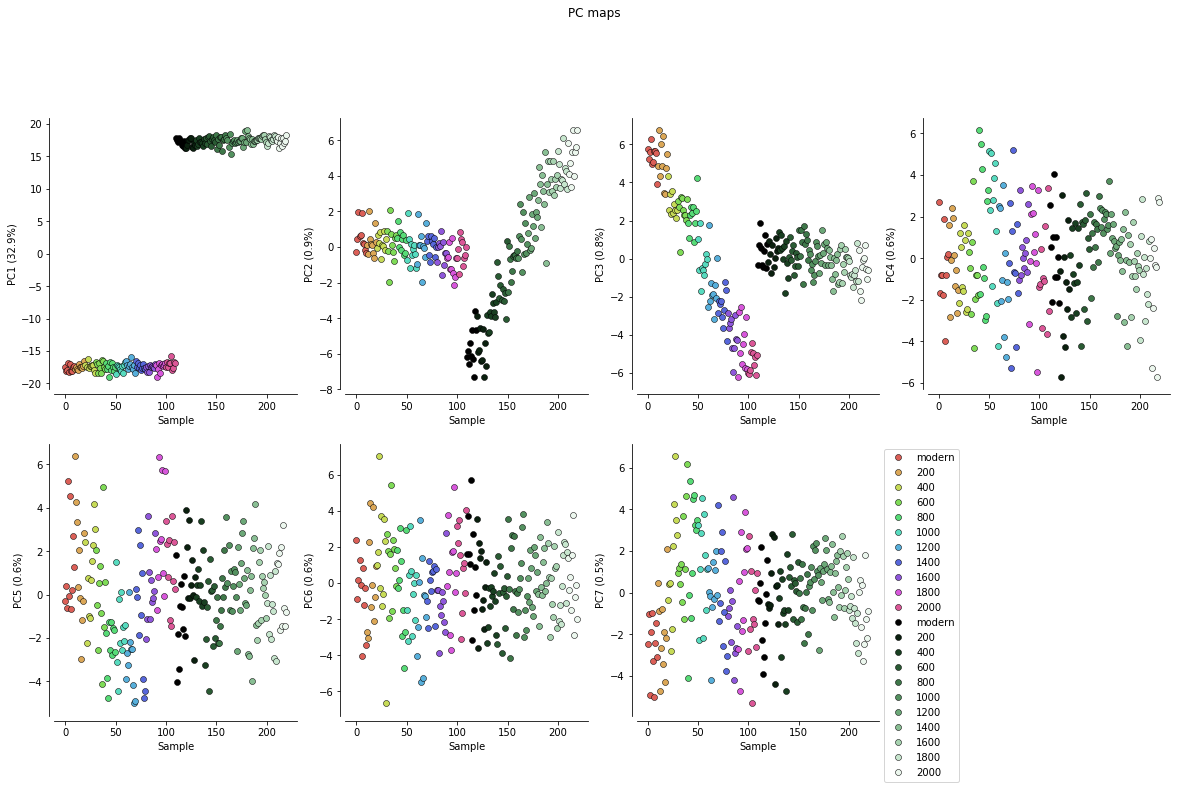

In [11]:
def plot_PC_maps(coords, model, pc, ax):
    """
    Plots each PC element against the sample number.
    """
    sns.despine(ax=ax, offset=5)
    ## pop1
    # modern samples
    y = coords[0:nbM, pc]
    x = np.arange(len(y))
    ax.plot(x, y, marker='o', linestyle=' ', label='modern', color=colors1['1_modern'], markersize=6, mec='k', mew=.5)
    i = nbM
    l = nbM
    # ancient samples
    for a in ages:
        y = coords[i:i+nbA, pc]
        l += len(y)
        ax.plot(list(range(i, l)), y, marker='o', linestyle=' ', label=a, color=colors1["1_" + str(a)], markersize=6, mec='k', mew=.5)
        i = l
    
    ## pop2
    # modern samples
    i = nbA * len(ages) + nbM
    y = coords[i:i+nbM, pc]
    x = np.arange(i, i+len(y))
    ax.plot(x, y, marker='o', linestyle=' ', label='modern', color=colors2['2_modern'], markersize=6, mec='k', mew=.5)
    i += nbM
    l = i
    # ancient samples
    for a in ages:
        y = coords[i:i+nbA, pc]
        l += len(y)
        ax.plot(list(range(i, l)), y, marker='o', linestyle=' ', label=a, color=colors2["2_" + str(a)], markersize=6, mec='k', mew=.5)
        i = l
    """    
    ## pop3
    # modern samples
    i = 2*(nbA * len(ages) + nbM)
    y = coords[i:i+nbM, pc]
    x = np.arange(i, i+len(y))
    ax.plot(x, y, marker='o', linestyle=' ', label='modern', color=colors3['3_modern'], markersize=6, mec='k', mew=.5)
    i += nbM
    l = i
    # ancient samples
    for a in ages:
        y = coords[i:i+nbA, pc]
        l += len(y)
        ax.plot(list(range(i, l)), y, marker='o', linestyle=' ', label=a, color=colors3["3_" + str(a)], markersize=6, mec='k', mew=.5)
        i = l
        
    ## pop4
    # modern samples
    i = 3*(nbA * len(ages) + nbM)
    y = coords[i:i+nbM, pc]
    x = np.arange(i, i+len(y))
    ax.plot(x, y, marker='o', linestyle=' ', label='modern', color=colors4['4_modern'], markersize=6, mec='k', mew=.5)
    i += nbM
    l = i
    # ancient samples
    for a in ages:
        y = coords[i:i+nbA, pc]
        l += len(y)
        ax.plot(list(range(i, l)), y, marker='o', linestyle=' ', label=a, color=colors4["4_" + str(a)], markersize=6, mec='k', mew=.5)
        i = l
    """
    ax.set_ylabel('PC%s (%.1f%%)' % (pc+1, model.explained_variance_ratio_[pc]*100))
    ax.set_xlabel('Sample')
    
fig = plt.figure(figsize=(20, 11))
ax = fig.add_subplot(2,4,1)
plot_PC_maps(coords, model, 0, ax)
ax = fig.add_subplot(2,4,2)
plot_PC_maps(coords, model, 1, ax)
ax = fig.add_subplot(2,4,3)
plot_PC_maps(coords, model, 2, ax)
ax = fig.add_subplot(2,4,4)
plot_PC_maps(coords, model, 3, ax)
ax = fig.add_subplot(2,4,5)
plot_PC_maps(coords, model, 4, ax)
ax = fig.add_subplot(2,4,6)
plot_PC_maps(coords, model, 5, ax)
ax = fig.add_subplot(2,4,7)
plot_PC_maps(coords, model, 6, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
fig.suptitle('PC maps', y=1.02)

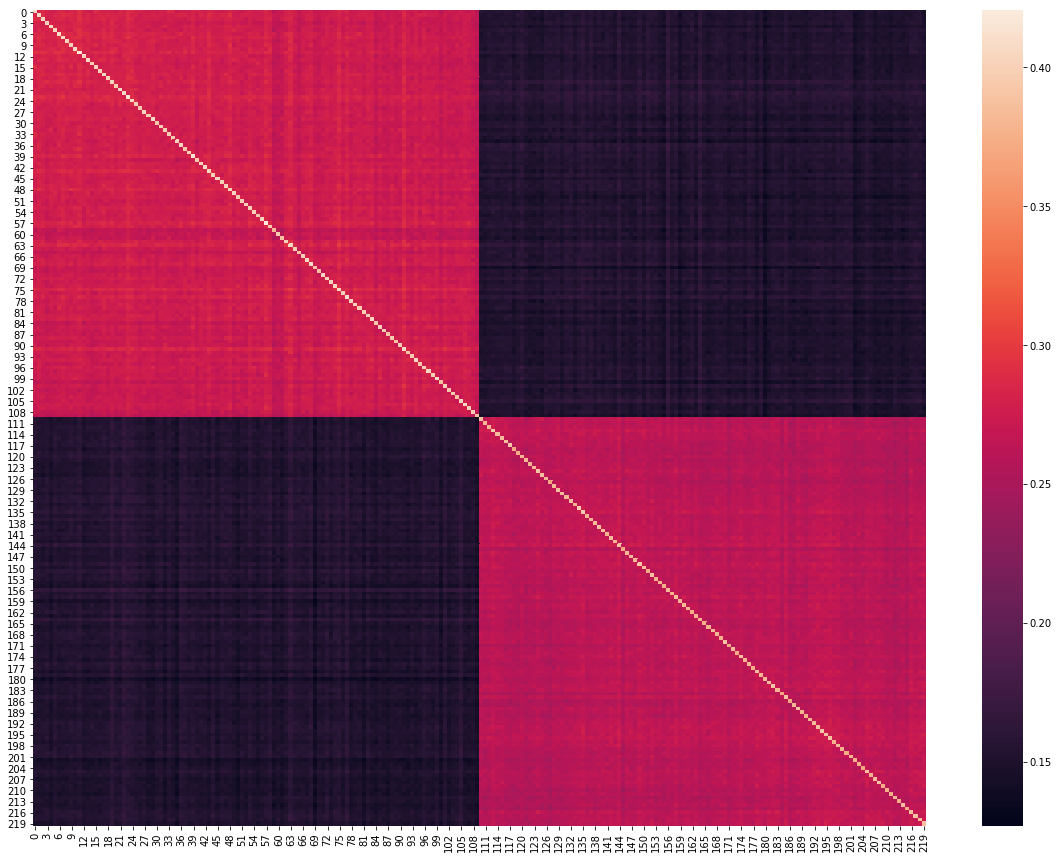

In [12]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(np.cov(gn, rowvar=False))